In [224]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Load COPX Data

In [102]:
copx = yf.Ticker("COPX").history(period="max", interval="1d").reset_index()
copx = copx.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'])
copx['Date'] = pd.to_datetime(copx['Date'].dt.date)
copx = copx.sort_values(by='Date')
copx.head(3)

,Date,Open,High,Low,Close,Volume
0,2010-04-20,33.153594,33.153594,32.597325,32.664078,1933
1,2010-04-21,32.486079,32.708586,32.063315,32.152317,2900
2,2010-04-22,32.018808,32.018808,31.529292,31.974308,3600


## Baseline

### Baseline - buy and hold

Buy at the very first open, sell at the most recent close.

In [28]:
copx_baseline = yf.Ticker("COPX").history(period="max", interval="1d").reset_index()
copx_baseline = copx_baseline.drop(columns=['Dividends', 'Stock Splits', 'Capital Gains'])
copx_baseline['Date'] = pd.to_datetime(copx_baseline['Date'].dt.date)
copx_baseline = copx_baseline.sort_values(by='Date')
copx_baseline = copx_baseline.dropna().reset_index()
copx_baseline = copx_baseline.drop(columns=['index'])
copx_baseline.set_index('Date', inplace=True)
copx_baseline.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2010-04-20,33.153590,33.153590,32.597322,32.664074,1933
2010-04-21,32.486075,32.708582,32.063311,32.152313,2900
2010-04-22,32.018810,32.018810,31.529293,31.974310,3600
2010-04-23,31.863053,32.085560,31.707299,32.085560,1100
2010-04-26,33.287107,33.287107,32.041065,32.575081,3600
2010-04-27,31.929803,32.041058,30.950771,30.950771,6733
2010-04-28,31.329040,31.329040,30.639267,31.017529,5133
2010-04-29,31.284533,31.284533,31.039774,31.039774,18133
2010-04-30,31.551541,31.551541,30.305500,30.305500,13467


In [433]:
def buy_and_hold(
    df,
    start_date,
    initial_capital=100,
):
    principal = initial_capital 
    portfolio_values = []
    dates = []

    buy_price = copx_baseline['Open'].iloc[0]
    for current_day in range(len(df)):
        date = df.index[current_day]
        if date <  pd.to_datetime(start_date):
            continue
        dates.append(date)
        close_price = df.iloc[current_day]['Close']
        portfolio_values.append(principal * close_price / buy_price )
    
    # Create a pandas Series for portfolio values
    portfolio_values = [principal] + portfolio_values
    dates = [dates[0]] + dates
    portfolio_series = pd.Series(
        portfolio_values, index=dates
    )

    # # Plot the portfolio value over time
    # plt.figure(figsize=(18, 6))
    # plt.plot(portfolio_series.index, portfolio_series.values, label="Portfolio Value")
    # plt.title("Portfolio Value Over Time")
    # plt.xlabel("Date")
    # plt.ylabel("Portfolio Value ($)")
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return portfolio_series


### Baseline - buy at the beginning of every investment window, and sell at the limit or at the end of the window 

In [417]:
def buy_with_horizon_and_limit(
    df,
    start_date,
    take_profit_threshold=1.01,
    stop_loss_threshold=0.92,
    investment_horizon=5,
    initial_capital=100,
):
    """
    Simulate a trading strategy based on take profit and stop loss thresholds.

    Parameters:
    - df (pd.DataFrame): DataFrame containing stock data with at least ['Open', 'High', 'Low', 'Close'] columns.
    - take_profit_threshold (float): Multiplier for take profit (e.g., 1.01 for 1% profit).
    - stop_loss_threshold (float): Multiplier for stop loss (e.g., 0.92 for 8% loss).
    - investment_horizon (int): Number of days to hold each trade.

    Returns:
    - portfolio_values (pd.Series): Portfolio value over time.
    """
    # Initialize variables
    capital = initial_capital
    portfolio_values = []
    position = None  # To track if we're in a trade
    entry_price = 0
    entry_day = -10000
    dates = []
    for current_day in range(len(df)):
        date = df.index[current_day]
        if date <  pd.to_datetime(start_date):
            continue
        dates.append(date)

        if position:
            # Calculate how many days have passed since the trade was entered
            days_passed = current_day - entry_day + 1
            
            # Get the Close price for the current day
            close_price = df.iloc[current_day]['Close']
            
            # Check for Take Profit
            if close_price >= entry_price * take_profit_threshold:
                # Calculate the profit
                capital *= (close_price / entry_price)
                portfolio_values.append(capital)
                position = False
                continue  # Move to next day
                
            # Check for Stop Loss
            if close_price <= entry_price * stop_loss_threshold:
                # Calculate the loss
                capital *= (close_price / entry_price)
                portfolio_values.append(capital)
                position = False
                continue  # Move to next day
                
            # Check if investment horizon is reached
            if days_passed >= investment_horizon:
                # Sell at Close price
                capital *= (close_price / entry_price)
                portfolio_values.append(capital)
                position = False
                continue  # Move to next day
                
            # If none of the above, keep the position open
            portfolio_values.append(capital)
        
        else:
            # Check if we're free to enter a new trade
            # Ensure that we have enough days left for the investment horizon
            if current_day % investment_horizon == 0:
                # Enter a new trade
                entry_price = df.iloc[current_day]['Open']
                position = True
                entry_day = current_day
                portfolio_values.append(capital)
            else:
                # Not enough data left to enter a new trade
                portfolio_values.append(capital)

    # If position is still open at the end, close it at the last close price
    if position:
        final_close = df.iloc[-1]["Close"]
        capital *= final_close / entry_price
        portfolio_values[-1] = capital  # Update the last portfolio value

    # Create a pandas Series for portfolio values
    portfolio_series = pd.Series(
        portfolio_values, index=dates
    )

    # # Plot the portfolio value over time
    # plt.figure(figsize=(18, 6))
    # plt.plot(portfolio_series.index, portfolio_series.values, label="Portfolio Value")
    # plt.title("Portfolio Value Over Time")
    # plt.xlabel("Date")
    # plt.ylabel("Portfolio Value ($)")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return portfolio_series




# Decision tree model

## Feature Engineering
### Using other ETFs

- First Quantum Minerals Ltd. (FM.TO)
- Lundin Mining Corporation (LUN.TO)
- Capstone Copper Corp. (CS.TO)
- Boliden AB (BOL.ST)

In [138]:
def fetch_data(tickers, start_date, end_date):
    """
    Fetch historical data for given tickers between start_date and end_date.

    Parameters:
    - tickers (list): List of ticker symbols.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    - data (dict): Dictionary of DataFrames keyed by ticker symbols.
    """
    data = {}
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        df = yf.download(ticker, start=start_date, end=end_date)
        if df.empty:
            print(f"Warning: No data fetched for {ticker}.")
        else:
            df.dropna(inplace=True)  # Drop rows with any NaN values
            print(f"Start date for {ticker} is {df.index.min()}")
            data[ticker] = df
    return data

In [133]:
def feature_engineering(main_ticker, related_etfs, lag_days_main, lag_days_etfs, first_day, last_day):
    """
    Perform feature engineering for the main ticker and related ETFs.

    Parameters:
    - main_ticker (str): The primary ticker symbol.
    - related_etfs (list): List of related ETF ticker symbols.
    - lag_days_main (list): List of lag days for the main ticker's close price.
    - lag_days_etfs (list): List of lag days for related ETFs' close prices.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    - final_df (pd.DataFrame): DataFrame with engineered features and target variable.
    """
    # Combine all tickers
    all_tickers = [main_ticker] + related_etfs

    # Fetch data
    data = fetch_data(all_tickers, first_day, last_day)

    # Extract main ticker data
    main_df = data.get(main_ticker)
    if main_df is None:
        raise ValueError(f"No data found for the main ticker: {main_ticker}")

    # Ensure 'Date' is a datetime index
    main_df.index = pd.to_datetime(main_df.index)

    # Sort the DataFrame by date
    main_df.sort_index(inplace=True)

    # Time features
    main_df['Day_of_Week'] = main_df.index.dayofweek
    main_df['Month'] = main_df.index.month

    # Yesterday's High and Low
    main_df['Yesterday_High'] = main_df['High'].shift(1)
    main_df['Yesterday_Low'] = main_df['Low'].shift(1)

    # Lagged Close Prices for main ticker
    for lag in lag_days_main:
        main_df[f'Close_Lag_{lag}'] = main_df['Close'].shift(lag)

    # Moving Averages
    for window in [3, 7, 14]:
        main_df[f'MA_{window}'] = main_df['Close'].rolling(window=window).mean()

    # Lagged Close Prices for related ETFs
    for etf in related_etfs:
        etf_df = data.get(etf)
        if etf_df is not None:
            for lag in lag_days_etfs:
                main_df[f'{etf}_Close_Lag_{lag}'] = etf_df['Close'].shift(lag)
        else:
            print(f"Data for {etf} is not available and will be skipped.")

    # Drop rows with any NaN values
    main_df.dropna(inplace=True)

    # Drop the last row as it has no target
    main_df = main_df[:-1]

    # Compile feature list
    feature_cols = [
        'Day_of_Week',
        'Month',
        'Yesterday_High',
        'Yesterday_Low'
    ]

    feature_cols += [f'Close_Lag_{lag}' for lag in lag_days_main]
    feature_cols += [f'MA_{window}' for window in [3, 7, 14]]

    for etf in related_etfs:
        feature_cols += [f'{etf}_Close_Lag_{lag}' for lag in lag_days_etfs]

    # Final DataFrame
    final_df = main_df[feature_cols].copy()

    return final_df

In [134]:
copx.head(10)

# Define 'begin' as the first trading day
first_day = copx['Date'].min()

# Define 'last_day' as the last trading day
last_day = copx['Date'].max()

print(f"first_day = {first_day}")
print(f"last_day = {last_day}")

first_day = 2010-04-20 00:00:00
last_day = 2024-12-10 00:00:00


In [196]:
MAIN_TICKER = 'COPX'  # Replace with your main ticker
RELATED_ETFS = ['FM.TO', 'LUN.TO', 'CS.TO', 'BOL.ST']
LAG_DAYS_MAIN = [1, 2, 3, 4, 5, 10, 15, 20]
LAG_DAYS_ETFS = [1, 2, 3, 4, 5]

# Perform feature engineering
feature_engineering_df = feature_engineering(
    main_ticker=MAIN_TICKER,
    related_etfs=RELATED_ETFS,
    lag_days_main=LAG_DAYS_MAIN,
    lag_days_etfs=LAG_DAYS_ETFS,
    first_day = first_day,
    last_day = last_day
).reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetching data for COPX...
Start date for COPX is 2010-04-20 00:00:00
Fetching data for FM.TO...
Start date for FM.TO is 2010-04-20 00:00:00
Fetching data for LUN.TO...
Start date for LUN.TO is 2010-04-20 00:00:00
Fetching data for CS.TO...
Start date for CS.TO is 2010-04-20 00:00:00
Fetching data for BOL.ST...



[*********************100%***********************]  1 of 1 completed


Start date for BOL.ST is 2010-04-20 00:00:00


In [258]:
def compute_target_expanded(
    df, horizon=5, take_profit_threshold=1.01, stop_loss_threshold=0.92
):
    """
    Expand the target computation to have each date and number of days left as a new row.

    Parameters:
    - df (pd.DataFrame): DataFrame containing at least ['Open', 'Close'] columns with Date as the index.
    - horizon (int): Number of days to look ahead for take profit and stop loss.
    - take_profit_threshold (float): Multiplier for take profit (e.g., 1.01 for 1% profit).
    - stop_loss_threshold (float): Multiplier for stop loss (e.g., 0.92 for 8% loss).

    Returns:
    - expanded_df (pd.DataFrame): Expanded DataFrame with len(df) * horizon rows.
      Columns: ['Date', 'Day_Left', 'Target']
    """
    # Initialize a list to collect all rows
    rows = []

    # Iterate over each row in the original DataFrame
    for i in range(len(df)):
        date = df.iloc[i]["Date"]
        buy_price = df.iloc[i]["Open"]

        # Iterate over each day left in the horizon
        for day_left in range(horizon):
            target = 0  # Default target
            hit_stop = False
            if i + day_left >= len(df):
                # Not enough days left; assume no take profit hit
                target = 0
                hit_stop = True
            else:
                for day in range(day_left + 1):
                    # Check if the day_left exceeds the DataFrame length
                    low_price = df.iloc[i + day]["Low"]
                    high_price = df.iloc[i + day]["High"]

                    # Check for Take Profit
                    if high_price >= buy_price * take_profit_threshold:
                        target = 1
                        hit_stop = True
                        break
                    # Check for Stop Loss
                    elif low_price <= buy_price * stop_loss_threshold:
                        target = 0
                        hit_stop = True
                        break

            # Append the new row
            rows.append({"Date": date, "Day_Left": day_left, "Target": target})

    # Create the expanded DataFrame
    expanded_df = pd.DataFrame(rows)
    expanded_df['Date'] = pd.to_datetime(expanded_df['Date'])
    return expanded_df

In [259]:
df_target = compute_target_expanded(copx)
df_target.columns

Index(['Date', 'Day_Left', 'Target'], dtype='object')

In [260]:
final_df = feature_engineering_df.droplevel('Ticker', axis=1).merge(df_target, on='Date')
final_df.columns

Index(['Date', 'Day_of_Week', 'Month', 'Yesterday_High', 'Yesterday_Low',
       'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4',
       'Close_Lag_5', 'Close_Lag_10', 'Close_Lag_15', 'Close_Lag_20', 'MA_3',
       'MA_7', 'MA_14', 'FM.TO_Close_Lag_1', 'FM.TO_Close_Lag_2',
       'FM.TO_Close_Lag_3', 'FM.TO_Close_Lag_4', 'FM.TO_Close_Lag_5',
       'LUN.TO_Close_Lag_1', 'LUN.TO_Close_Lag_2', 'LUN.TO_Close_Lag_3',
       'LUN.TO_Close_Lag_4', 'LUN.TO_Close_Lag_5', 'CS.TO_Close_Lag_1',
       'CS.TO_Close_Lag_2', 'CS.TO_Close_Lag_3', 'CS.TO_Close_Lag_4',
       'CS.TO_Close_Lag_5', 'BOL.ST_Close_Lag_1', 'BOL.ST_Close_Lag_2',
       'BOL.ST_Close_Lag_3', 'BOL.ST_Close_Lag_4', 'BOL.ST_Close_Lag_5',
       'Day_Left', 'Target'],
      dtype='object')

## Train the xgboost classifier

In [231]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report


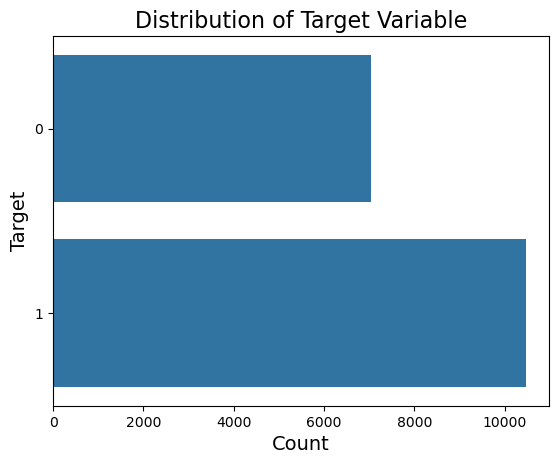

In [339]:
sns.countplot(y='Target', data=final_df)
plt.title('Distribution of Target Variable', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Target', fontsize=14)
plt.show()

In [395]:
df = final_df
split_index = int(0.8* len(df))

first_test_date =df[split_index:]['Date'].min()
df.drop("Date", axis=1, inplace=True)
# Define target and features
X = df.drop("Target", axis=1)
y = df["Target"]

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

train_0 = X_train[y_train == 0]
train_1 = X_train[y_train == 1]

# Determine the smaller count between the two classes
min_count = min(len(train_0), len(train_1))

# Randomly sample the same number of examples from each group
train_0_balanced = train_0.sample(n=min_count, random_state=42)
train_1_balanced = train_1.sample(n=min_count, random_state=42)

# Combine the balanced data
X_train = pd.concat([train_0_balanced, train_1_balanced])

# Adjust y_train accordingly
y_train = y_train.loc[X_train.index]


# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )




# Identify categorical and numerical features
categorical_features = ["Day_of_Week", "Month", "Day_Left"]
numerical_features = [col for col in X.columns if col not in categorical_features]


# Define preprocessing pipelines
pipeline = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    ("num", StandardScaler(), numerical_features),
                    (
                        "cat",
                        OneHotEncoder(handle_unknown="ignore"),
                        categorical_features,
                    ),
                ]
            ),
        ),
        (
            "xgb",
            XGBClassifier(
                objective="binary:logistic",
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=42,
            ),
        ),
    ]
)

# Define hyperparameter grid
param_grid = {
    "xgb__n_estimators": [150, 200],
    "xgb__max_depth": [5, 7, 9],
    "xgb__learning_rate": [0.01, 0.2],
    "xgb__subsample": [0.7],
    "xgb__colsample_bytree": [0.8],
    "xgb__gamma": [0.1],
    "xgb__reg_alpha": [0.5],
    "xgb__reg_lambda": [2],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=12,
    verbose=2,
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Output best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best CV ROC-AUC score: ", grid_search.best_score_)

# Predict on test set
y_pred = grid_search.predict(X_test)
y_proba = grid_search.predict_proba(X_test)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0.1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.5, xgb__reg_lambda=2, xgb__subsample=0.7; total time=   0.3s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0.1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.5, xgb__reg_lambda=2, xgb__subsample=0.7; total time=   0.4s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0.1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=200, xgb__reg_alpha=0.5, xgb__reg_lambda=2, xgb__subsample=0.7; total time=   0.4s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0.1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.5, xgb__reg_lambda=2, xgb__subsample=0.7; total time=   0.4s
[CV] END xgb__colsample_bytree=0.8, xgb__gamma=0.1, xgb__learning_rate=0.01, xgb__max_depth=5, xgb__n_estimators=150, xgb__reg_alpha=0.5, xgb__reg_lambda=2

In [396]:
def get_close_price(date):
    return copx.at[copx[copx['Date'] == date].index[0], 'Close']
def get_open_price(date):
    return copx.at[copx[copx['Date'] == date].index[0], 'Open']
def get_day_left(current_day, investment_horizon):
    return investment_horizon - current_day % investment_horizon - 1
assert get_day_left(0, 5) == 4
assert get_day_left(2, 5) == 2
assert get_day_left(3, 5) == 1
assert get_day_left(4, 5) == 0

In [412]:
def xgboost_back_test(df, start_date, investment_horizon=5, take_profit_threshold=1.01, stop_loss_threshold=0.92, capital = 100.0):
    capital = 100.0
    in_position = False
    entry_price = 0.0
    num_trades = 0
    entry_day = -1000000
    portfolio_values = []
    all_dates = []
    for current_day in range(len(df)):
        # Check if currently in a trade
        date = df.loc[current_day, 'Date']
        if date < pd.to_datetime(start_date):
            continue
        all_dates.append(date)
        if in_position:
            # Calculate how many days have passed since the trade was entered
            days_passed = current_day - entry_day + 1
            
            # Get the Close price for the current day
            close_price = get_close_price(date)
            
            # Check for Take Profit
            if close_price >= entry_price * take_profit_threshold:
                # Calculate the profit
                capital *= (close_price / entry_price)
                portfolio_values.append(capital)
                in_position = False
                continue  # Move to next day
                
            # Check for Stop Loss
            if close_price <= entry_price * stop_loss_threshold:
                # Calculate the loss
                capital *= (close_price / entry_price)
                portfolio_values.append(capital)
                in_position = False
                continue  # Move to next day
                
            # Check if investment horizon is reached
            if days_passed >= investment_horizon:
                # Sell at Close price
                capital *= (close_price / entry_price)
                portfolio_values.append(capital)
                in_position = False
                continue  # Move to next day
                
            # If none of the above, keep the position open
            portfolio_values.append(capital)
        # Initiate a new trade every 'horizon' steps if not in a position
        if not in_position:
            if current_day % investment_horizon == 0:
                row = df.iloc[[current_day]].copy()
                row = row.drop(columns=['Date'])
                row['Day_Left'] = get_day_left(current_day, investment_horizon)
                is_buy = grid_search.predict(row)[0]
                if is_buy:
                    entry_price = get_open_price(date)
                    in_position = True
                    entry_day = current_day
                    num_trades += 1

            portfolio_values.append(capital)
                
    # If position is still open at the end, close it at the last close price
    if in_position:
        final_close = get_close_price(date)
        capital *= final_close / entry_price
        portfolio_values[-1] = capital  # Update the last portfolio value

    # Create a pandas Series for portfolio values
    portfolio_series = pd.Series(
        portfolio_values, index=all_dates
    )

    # # Plot the portfolio value over time
    # plt.figure(figsize=(18, 6))
    # plt.plot(portfolio_series.index, portfolio_series.values, label="Portfolio Value")
    # plt.title("Portfolio Value Over Time")
    # plt.xlabel("Date")
    # plt.ylabel("Portfolio Value ($)")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return portfolio_series



In [434]:
xgboost_series = xgboost_back_test(feature_engineering_df.droplevel("Ticker", axis=1), first_test_date)
with_limit_series = buy_with_horizon_and_limit(copx_baseline, first_test_date)
buy_and_hold_series = buy_and_hold(copx_baseline, first_test_date)

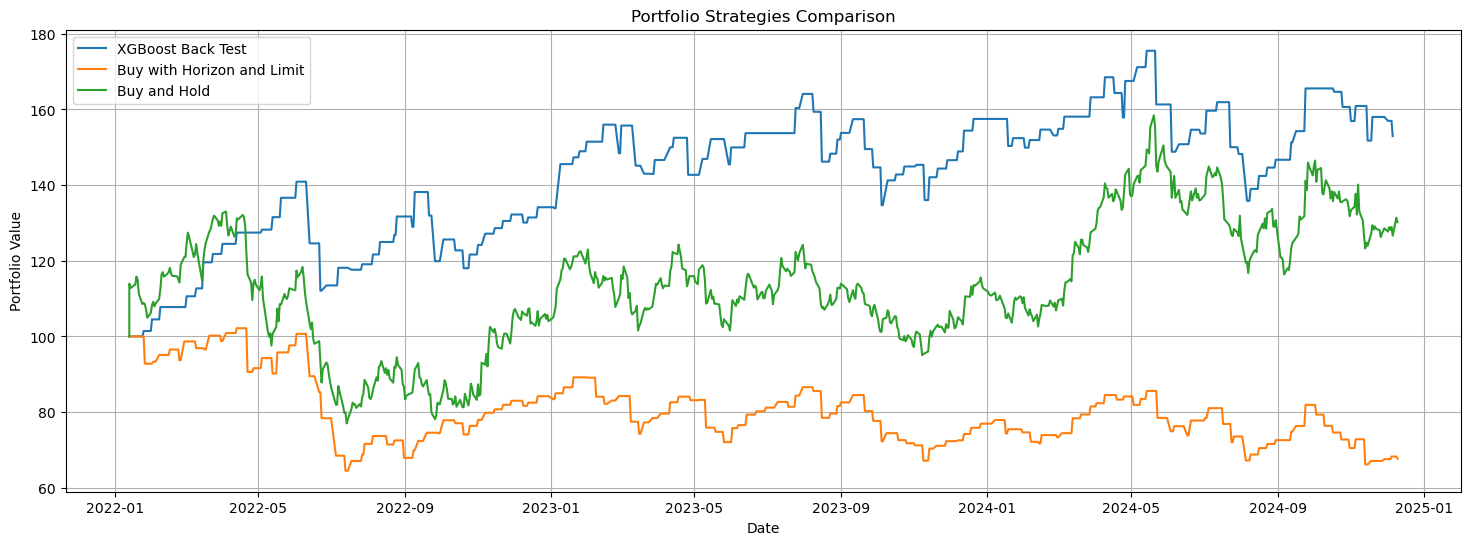

In [435]:
# Plot the series
plt.figure(figsize=(18, 6))
plt.plot(xgboost_series.index, xgboost_series.values, label="XGBoost Back Test")
plt.plot(with_limit_series.index, with_limit_series.values, label="Buy with Horizon and Limit")
plt.plot(buy_and_hold_series.index, buy_and_hold_series.values, label="Buy and Hold")

# Customize the plot
plt.title("Portfolio Strategies Comparison")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

We developed an XGBoost Classifier that outperformed the traditional buy-and-hold strategy. The investment horizon was set to 5 days, with a take-profit level of 1.01 and a stop-loss at 0.92. Only one trade was opened per investment horizon, and positions were closed either when the price hit the stop-loss/take-profit levels or at the close of the final day if neither condition was met. The model achieved an accuracy of 70%, though there remains room for further improvement.

To enhance model inputs, we incorporated lagged features from related assets, including First Quantum Minerals Ltd. (FM.TO), Lundin Mining Corporation (LUN.TO), Capstone Copper Corp. (CS.TO), and Boliden AB (BOL.ST), with lags ranging from 1 to 5 days. For the primary asset (COPX), we used lagged features spanning 1, 2, 3, 4, 5, 10, 15, and 20 days, along with moving averages over 3, 7, and 14 days. Temporal features such as the day of the week, month, and the number of days remaining in the investment horizon were also added to capture seasonality and timing effects.